# Longitudinal Distribution Check

In [1]:
import imageio
import numpy as np
import PyNAFF as pnf
import scipy.io as sio 
import matplotlib.cm as cm
from math import log10, floor
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

### Function Definitions

In [3]:
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [4]:
def round_sig(x, sig=4):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [5]:
def add_input_file(dd, filename, label):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [6]:
class resonance_lines(object):
	
	def __init__(self, Qx_range, Qy_range, orders, periodicity):
		
		if np.std(Qx_range):
			self.Qx_min = np.min(Qx_range)
			self.Qx_max = np.max(Qx_range)
		else:
			self.Qx_min = np.floor(Qx_range)-0.05
			self.Qx_max = np.floor(Qx_range)+1.05
		if np.std(Qy_range):
			self.Qy_min = np.min(Qy_range)
			self.Qy_max = np.max(Qy_range)
		else:
			self.Qy_min = np.floor(Qy_range)-0.05
			self.Qy_max = np.floor(Qy_range)+1.05

		self.periodicity = periodicity
									
		nx, ny = [], []

		for order in np.nditer(np.array(orders)):
			t = np.array(range(-order, order+1))
			nx.extend(order - np.abs(t))
			ny.extend(t)
		nx = np.array(nx)
		ny = np.array(ny)
	
		cextr = np.array([nx*np.floor(self.Qx_min)+ny*np.floor(self.Qy_min), \
						  nx*np.ceil(self.Qx_max)+ny*np.floor(self.Qy_min), \
						  nx*np.floor(self.Qx_min)+ny*np.ceil(self.Qy_max), \
						  nx*np.ceil(self.Qx_max)+ny*np.ceil(self.Qy_max)], dtype='int')
		cmin = np.min(cextr, axis=0)
		cmax = np.max(cextr, axis=0)
		res_sum = [range(cmin[i], cmax[i]+1) for i in xrange(cextr.shape[1])]								
		self.resonance_list = zip(nx, ny, res_sum)
		
	def plot_resonance(self, figure_object = None):	
		plt.ion()
		if figure_object:
			fig = figure_object
			plt.figure(fig.number)
		else:
			fig = plt.figure()
		Qx_min = self.Qx_min
		Qx_max = self.Qx_max
		Qy_min = self.Qy_min
		Qy_max = self.Qy_max 
		plt.xlim(Qx_min, Qx_max)
		plt.ylim(Qy_min, Qy_max)
		plt.xlabel('Qx')
		plt.ylabel('Qy')
		for resonance in self.resonance_list:
			nx = resonance[0]
			ny = resonance[1]
			for res_sum in resonance[2]:
				if ny:
					line, = plt.plot([Qx_min, Qx_max], \
					    [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny])
				else:
					line, = plt.plot([np.float(res_sum)/nx, np.float(res_sum)/nx],[Qy_min, Qy_max])
				if ny%2:
					plt.setp(line, linestyle='--') # for skew resonances
				if res_sum%self.periodicity:
					plt.setp(line, color='b')	# non-systematic resonances
				else:
					plt.setp(line, color='r', linewidth=2.0) # systematic resonances
		plt.draw()
		return fig
		
	def print_resonances(self):
		for resonance in self.resonance_list:
			for res_sum in resonance[2]:
				'''
				print str(resonance[0]).rjust(3), 'Qx ', ("+", "-")[resonance[1]<0], \
					  str(abs(resonance[1])).rjust(2), 'Qy = ', str(res_sum).rjust(3), \
					  '\t', ("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0]
				'''
				print '%s %s%s = %s\t%s'%(str(resonance[0]).rjust(2), ("+", "-")[resonance[1]<0], \
						str(abs(resonance[1])).rjust(2), str(res_sum).rjust(4), \
						("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0])


In [7]:
def z_to_time(z, beta=0.947643035549): #beta for 2 GeV
    c = 299792458
    return z / (c * beta)

In [8]:
def add_bunch_file(dd, filename, label):
	f = filename
	p = sio.loadmat(f, squeeze_me=True,  struct_as_record=False)['particles']
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [10]:
# Create dd dictionary
dd1 = dict()

dd1 = add_input_file(dd1, '00_00/bunch_output/mainbunch_-000001.mat', '1.3')
dd1 = add_input_file(dd1, '00_01/bunch_output/mainbunch_-000001.mat', '1.6')
dd1 = add_input_file(dd1, '00_02/bunch_output/mainbunch_-000001.mat', '1.9')
dd1 = add_input_file(dd1, '00_03/bunch_output/mainbunch_-000001.mat', '2.3')
dd1 = add_input_file(dd1, '00_04/bunch_output/mainbunch_-000001.mat', '2.6')

save_folder = 'Plots'
sc = 'SbS'
Case = 'Tomo'
legend_label = '2023'    
main_label = 'MD211'

	Added output data from  00_00/bunch_output/mainbunch_-000001.mat 	 dictionary key:  1.3
	Added output data from  00_01/bunch_output/mainbunch_-000001.mat 	 dictionary key:  1.6
	Added output data from  00_02/bunch_output/mainbunch_-000001.mat 	 dictionary key:  1.9
	Added output data from  00_03/bunch_output/mainbunch_-000001.mat 	 dictionary key:  2.3
	Added output data from  00_04/bunch_output/mainbunch_-000001.mat 	 dictionary key:  2.6


In [11]:
dd1['1.3']['particles']['z'][0][0]

array([[-15.77790352,   3.23699032,  20.15195455, ...,   0.38007724,
         13.51568886,  19.9133014 ]])

In [12]:
dd1['1.3']['particles']['x'][0][0][0]

array([-0.00499229, -0.00277195, -0.00078692, ..., -0.00137371,
        0.00398562,  0.00733053])

In [13]:
# If using add_bunch_file, access like:
# dd1['2021'].x

## Longitudinal Distn

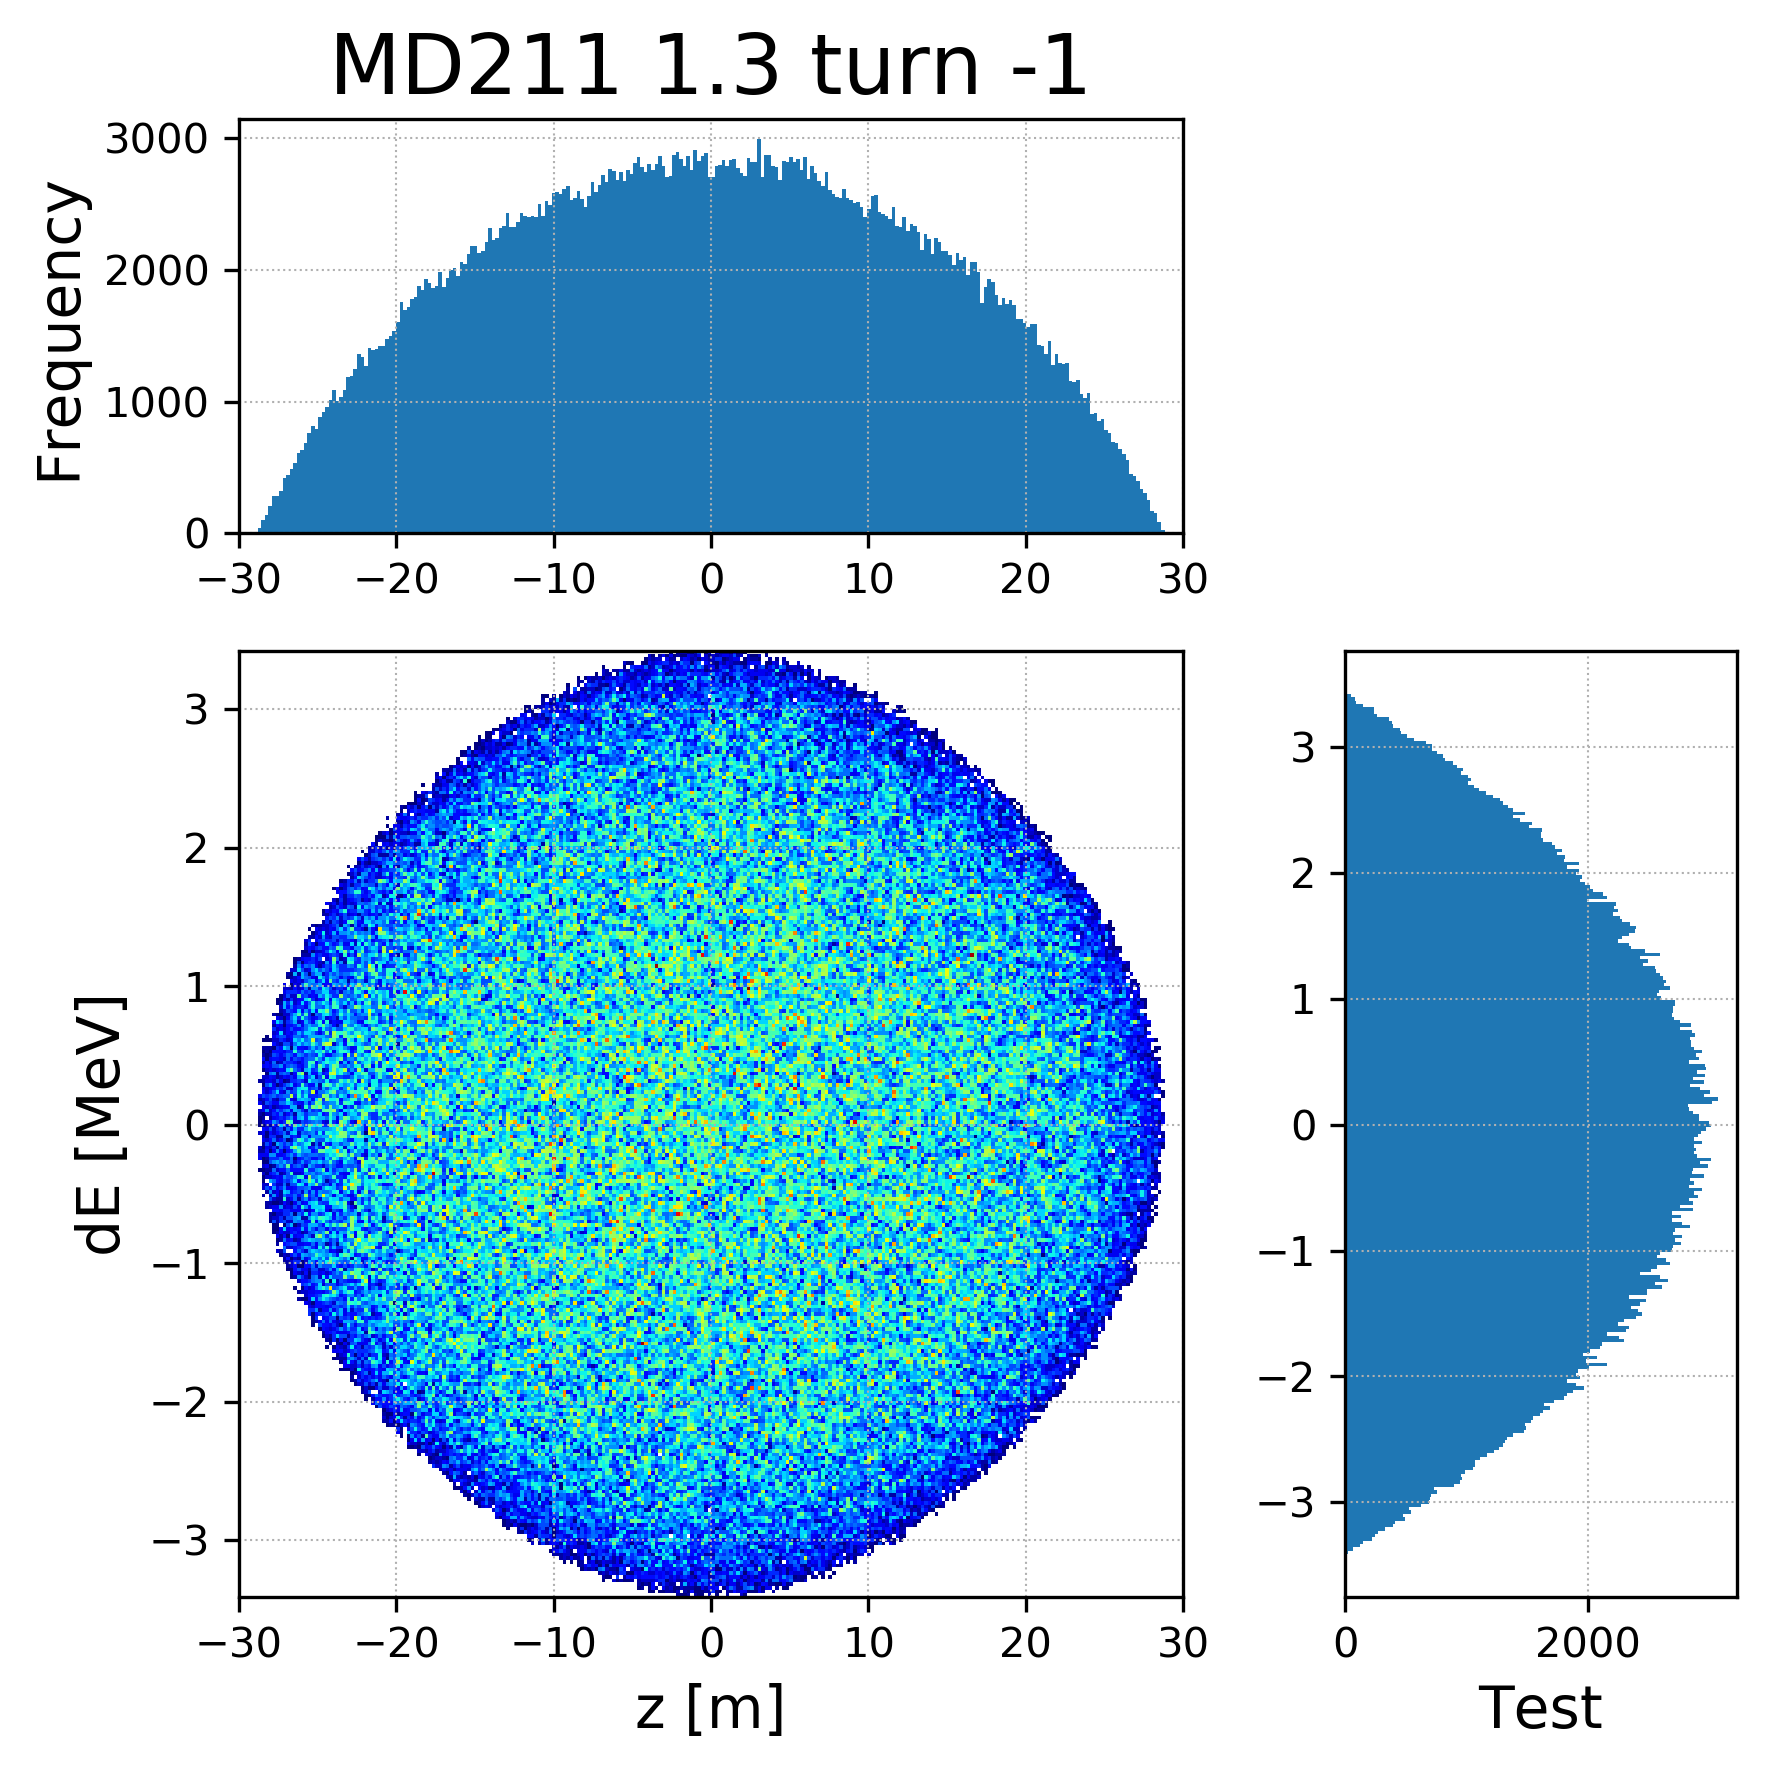

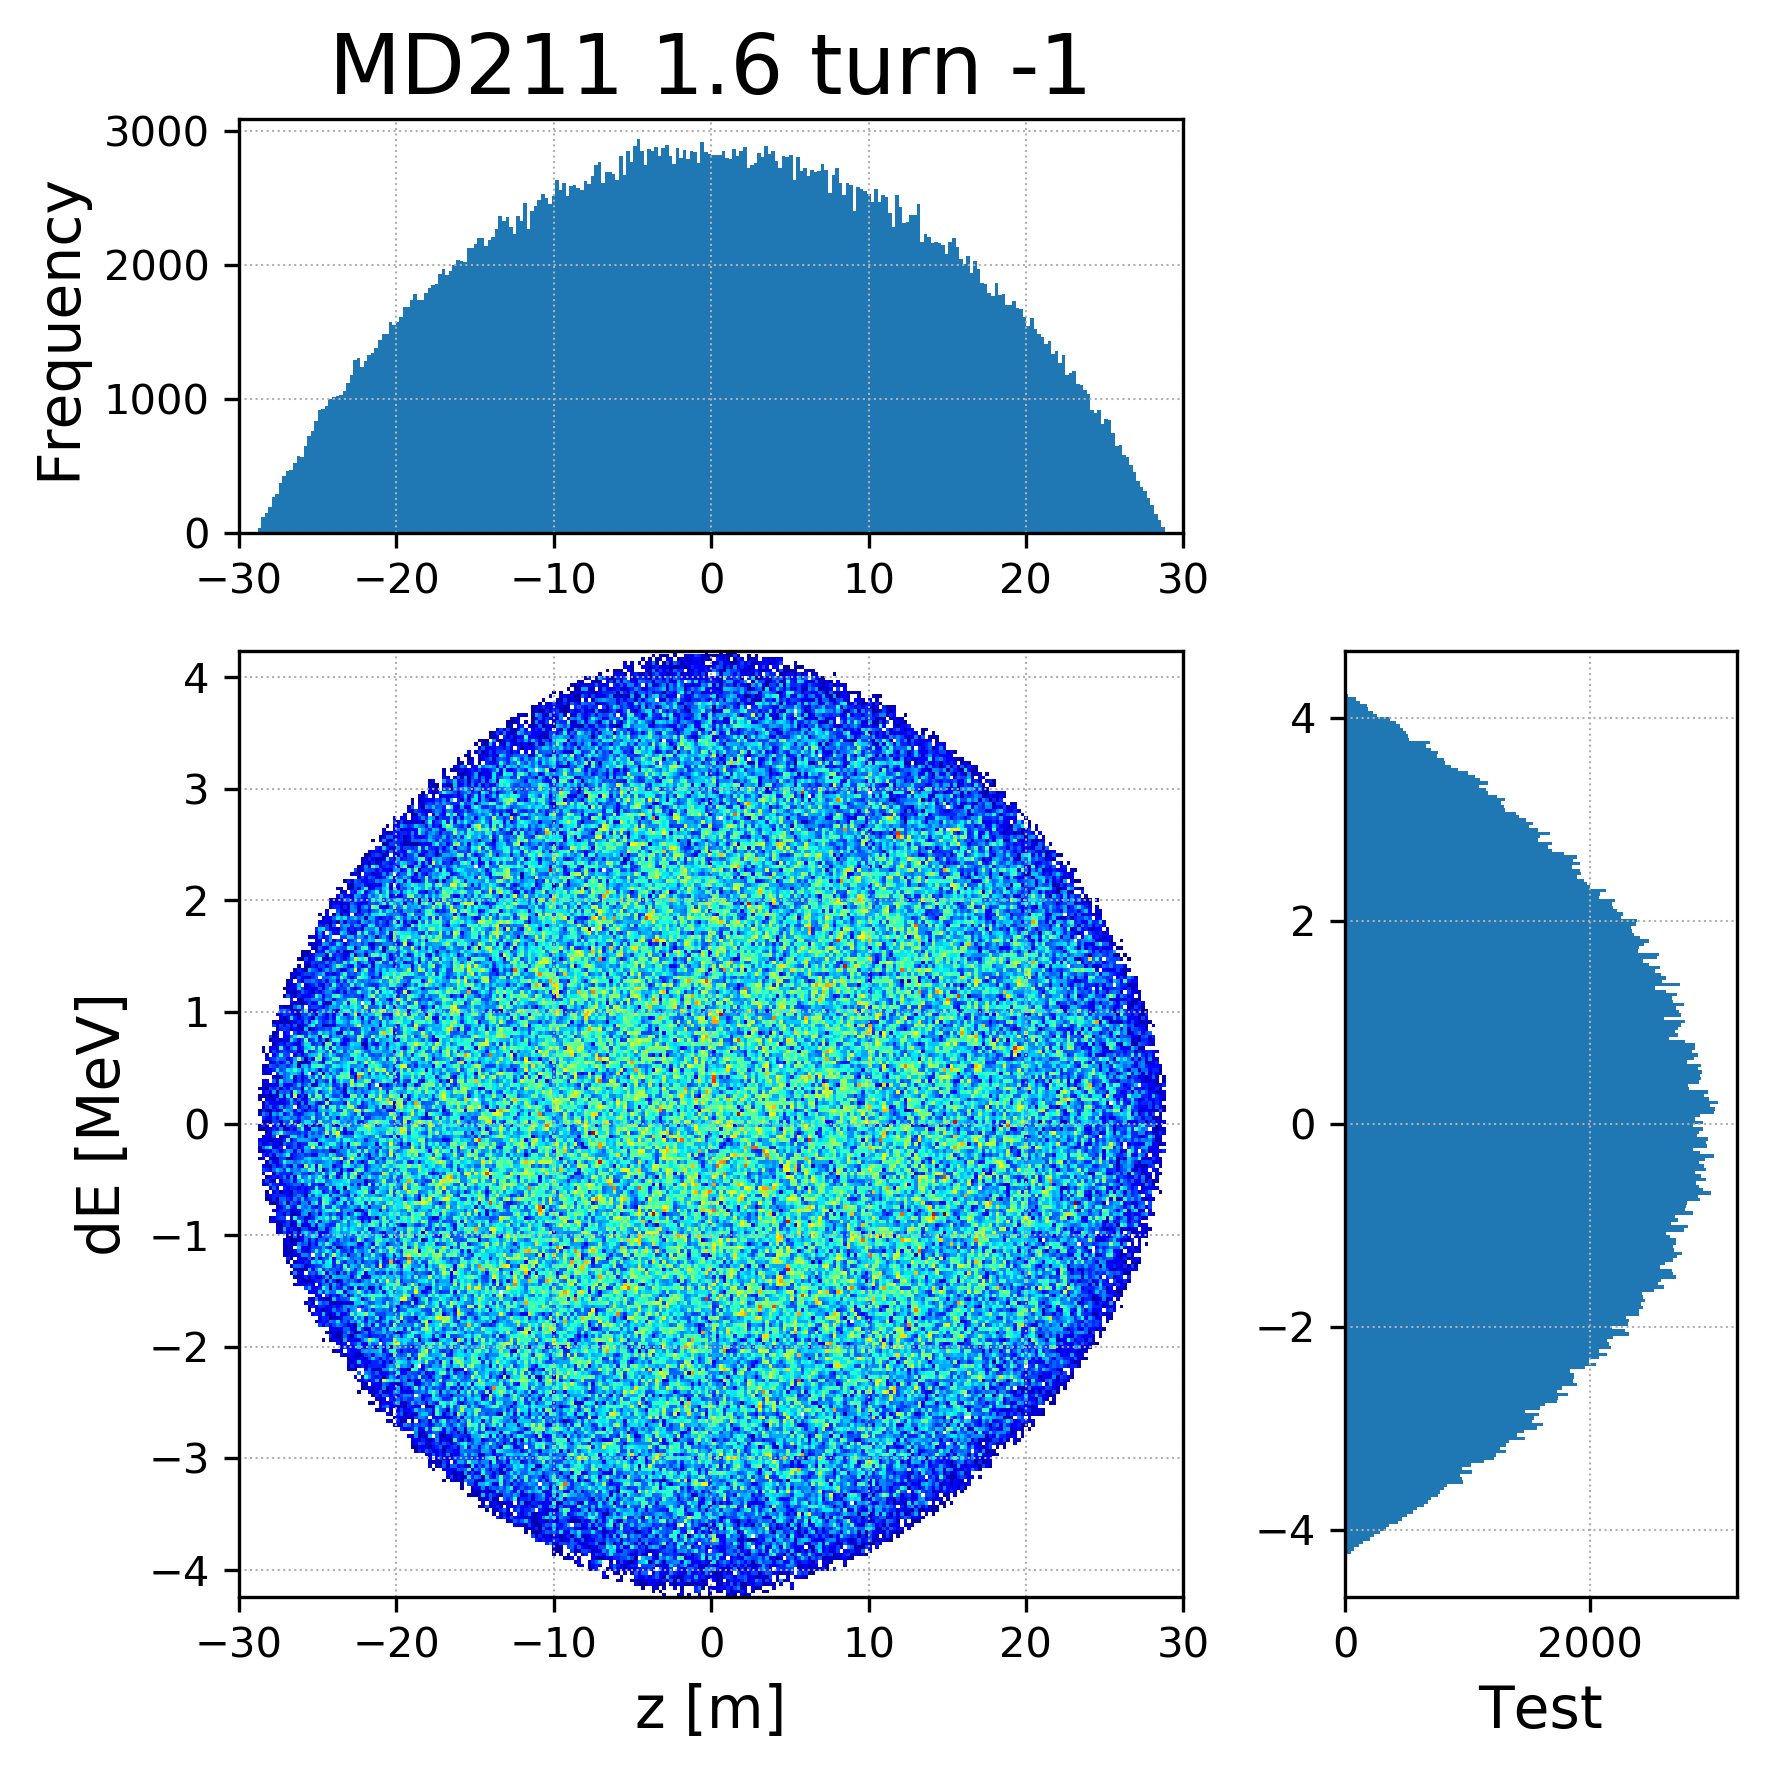

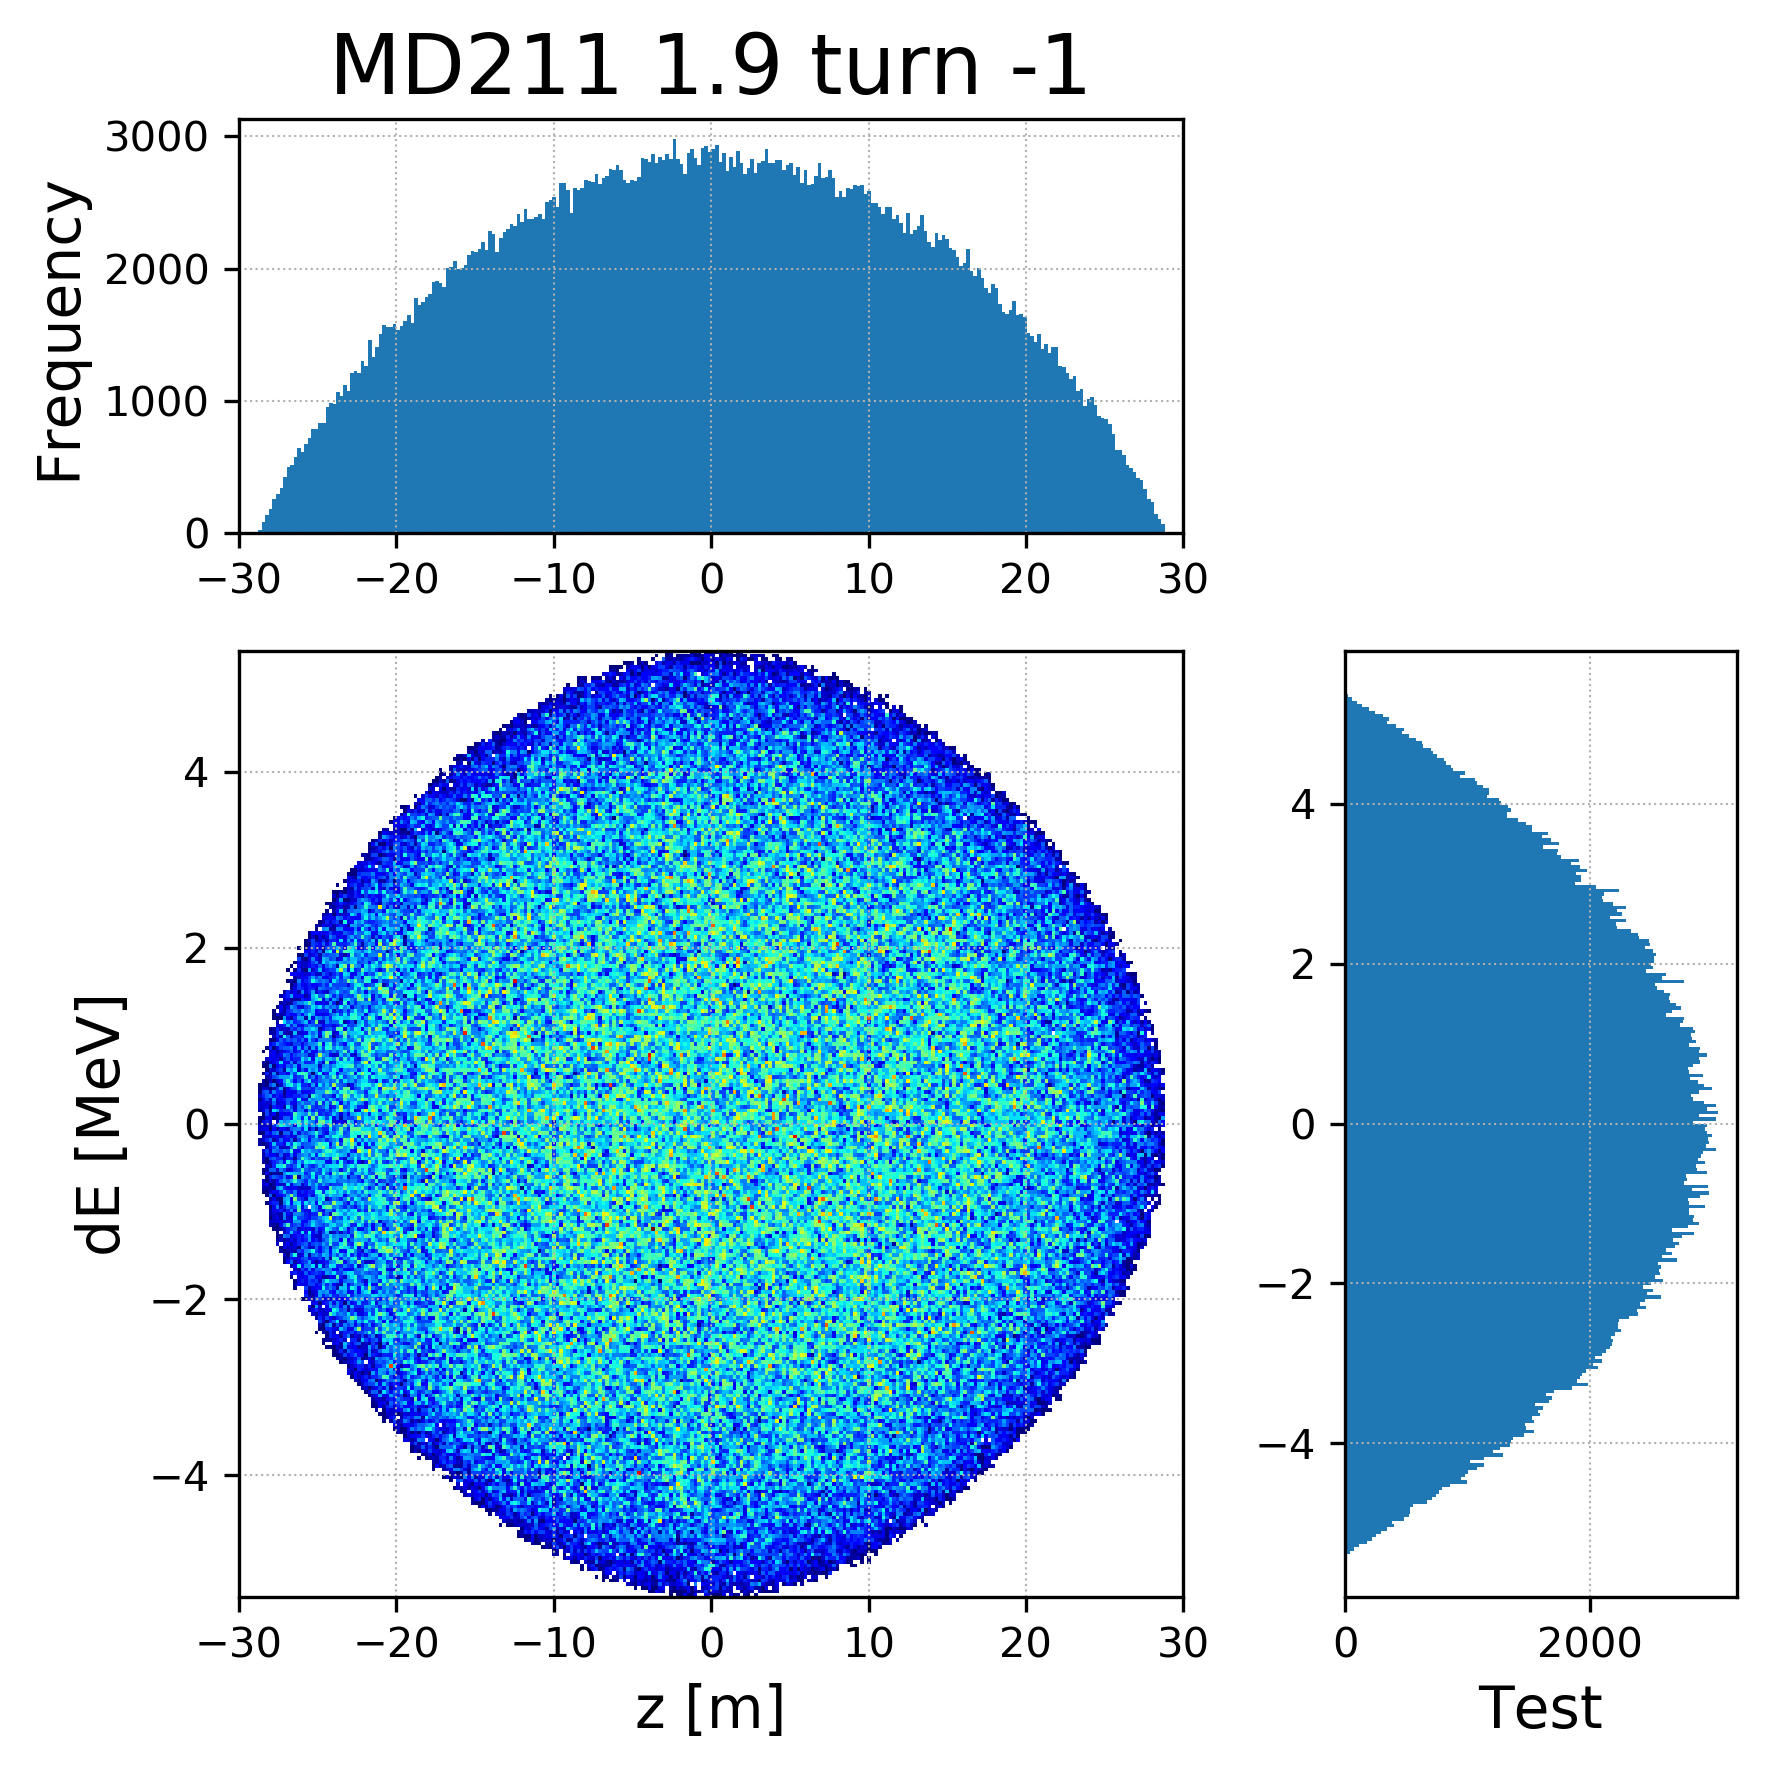

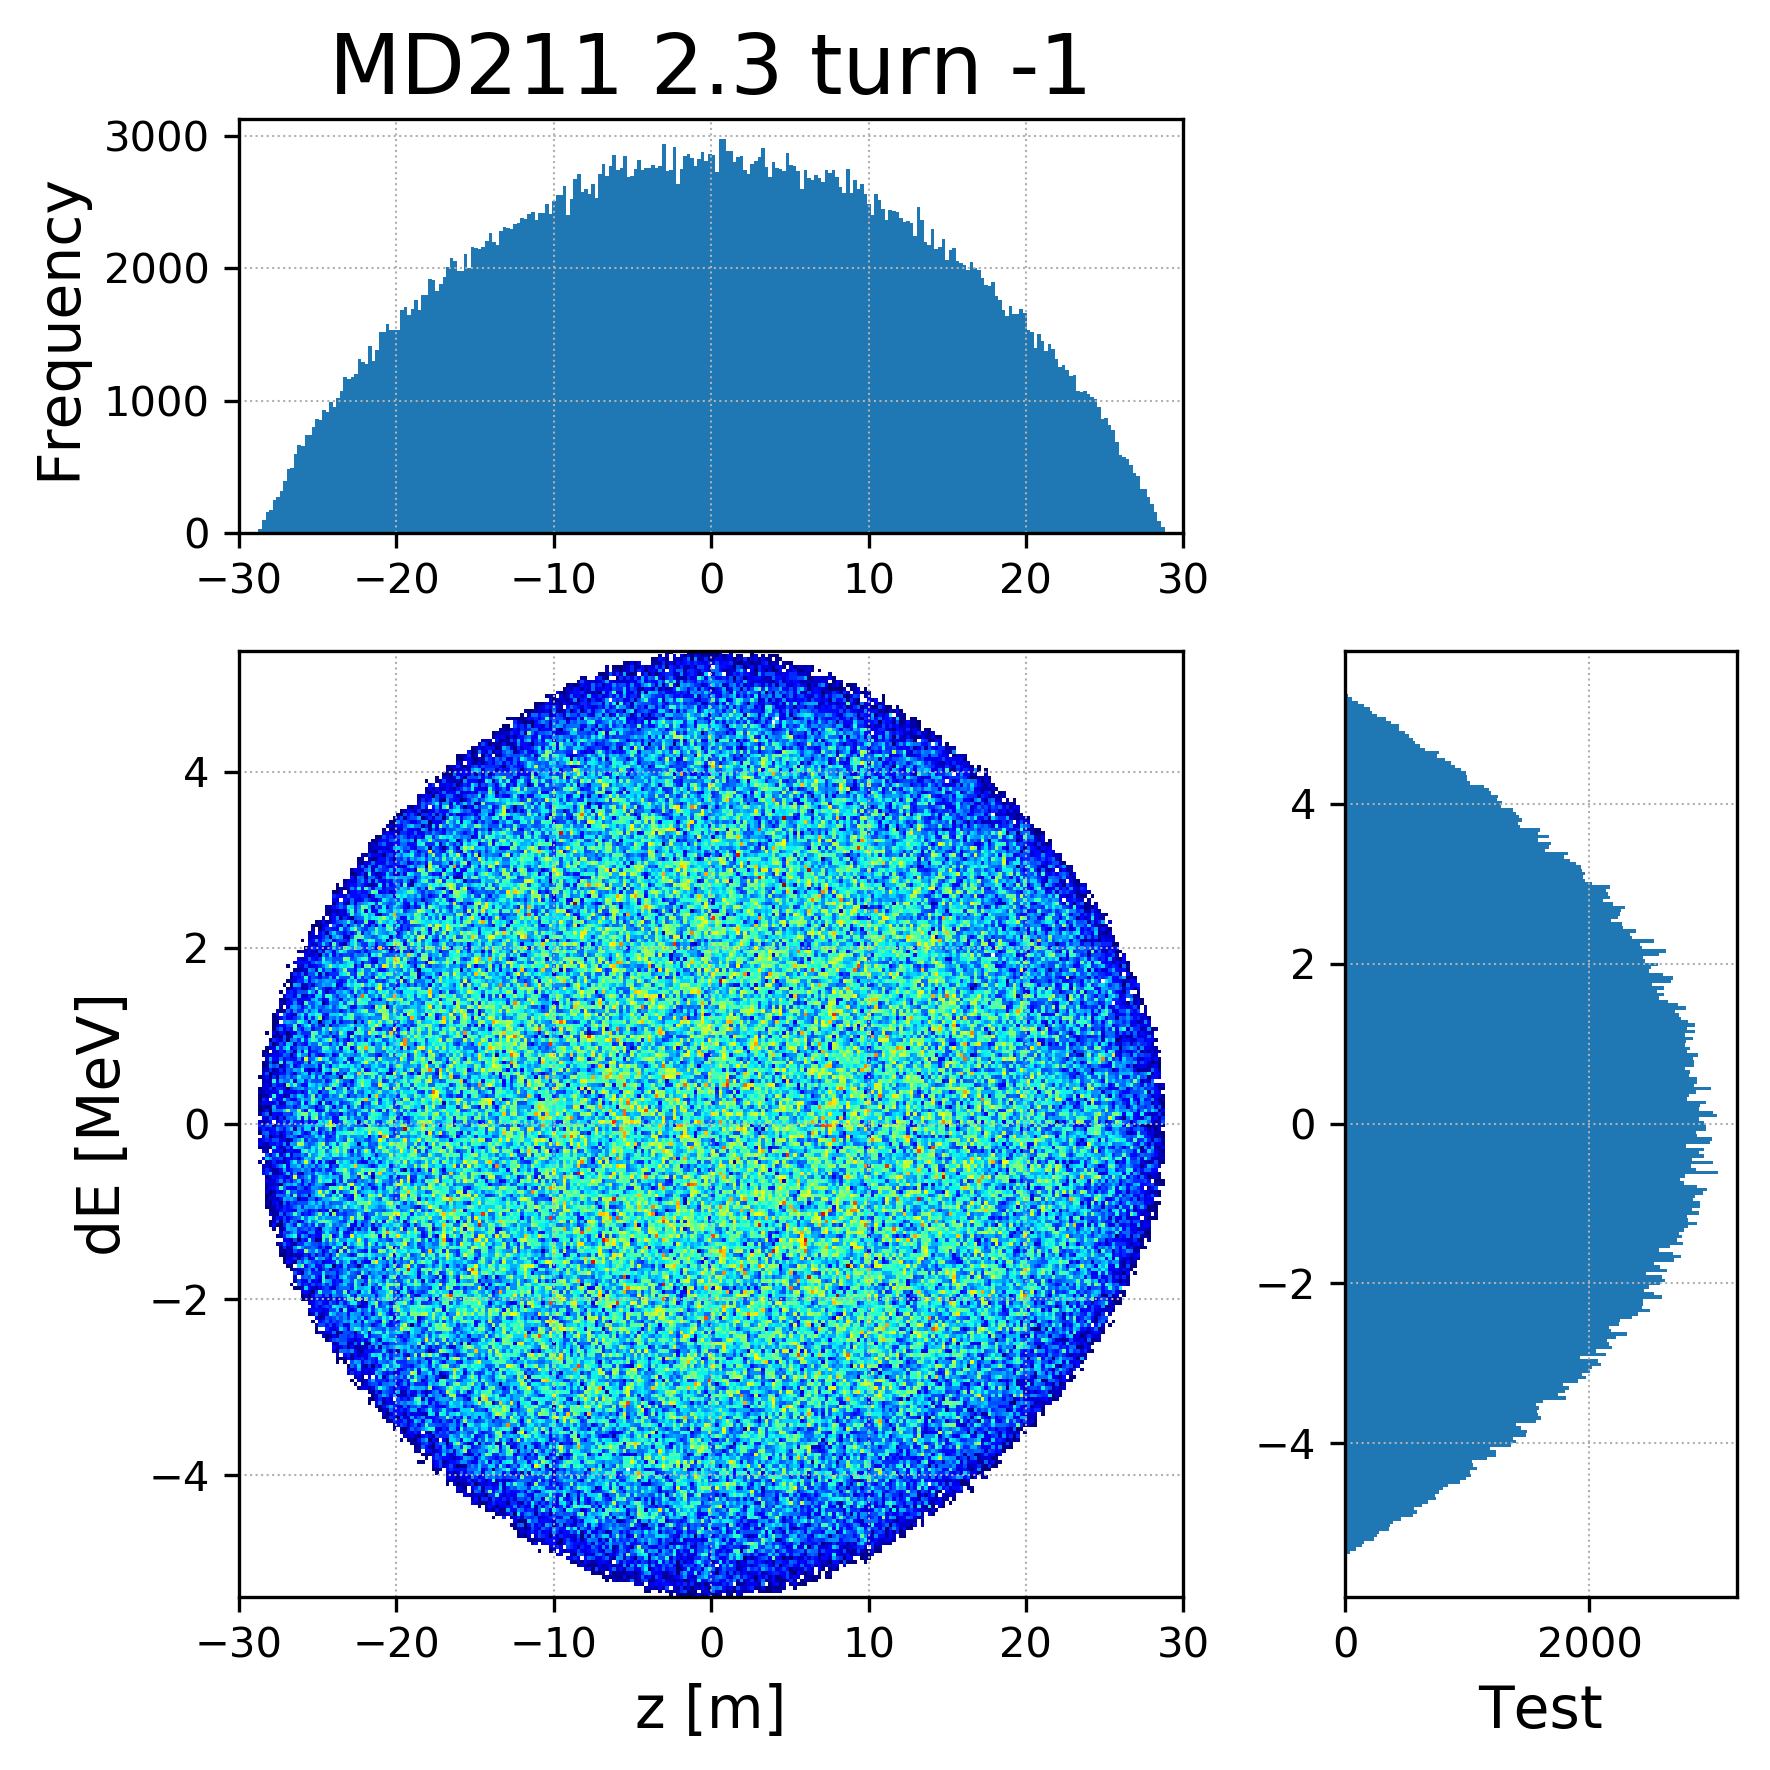

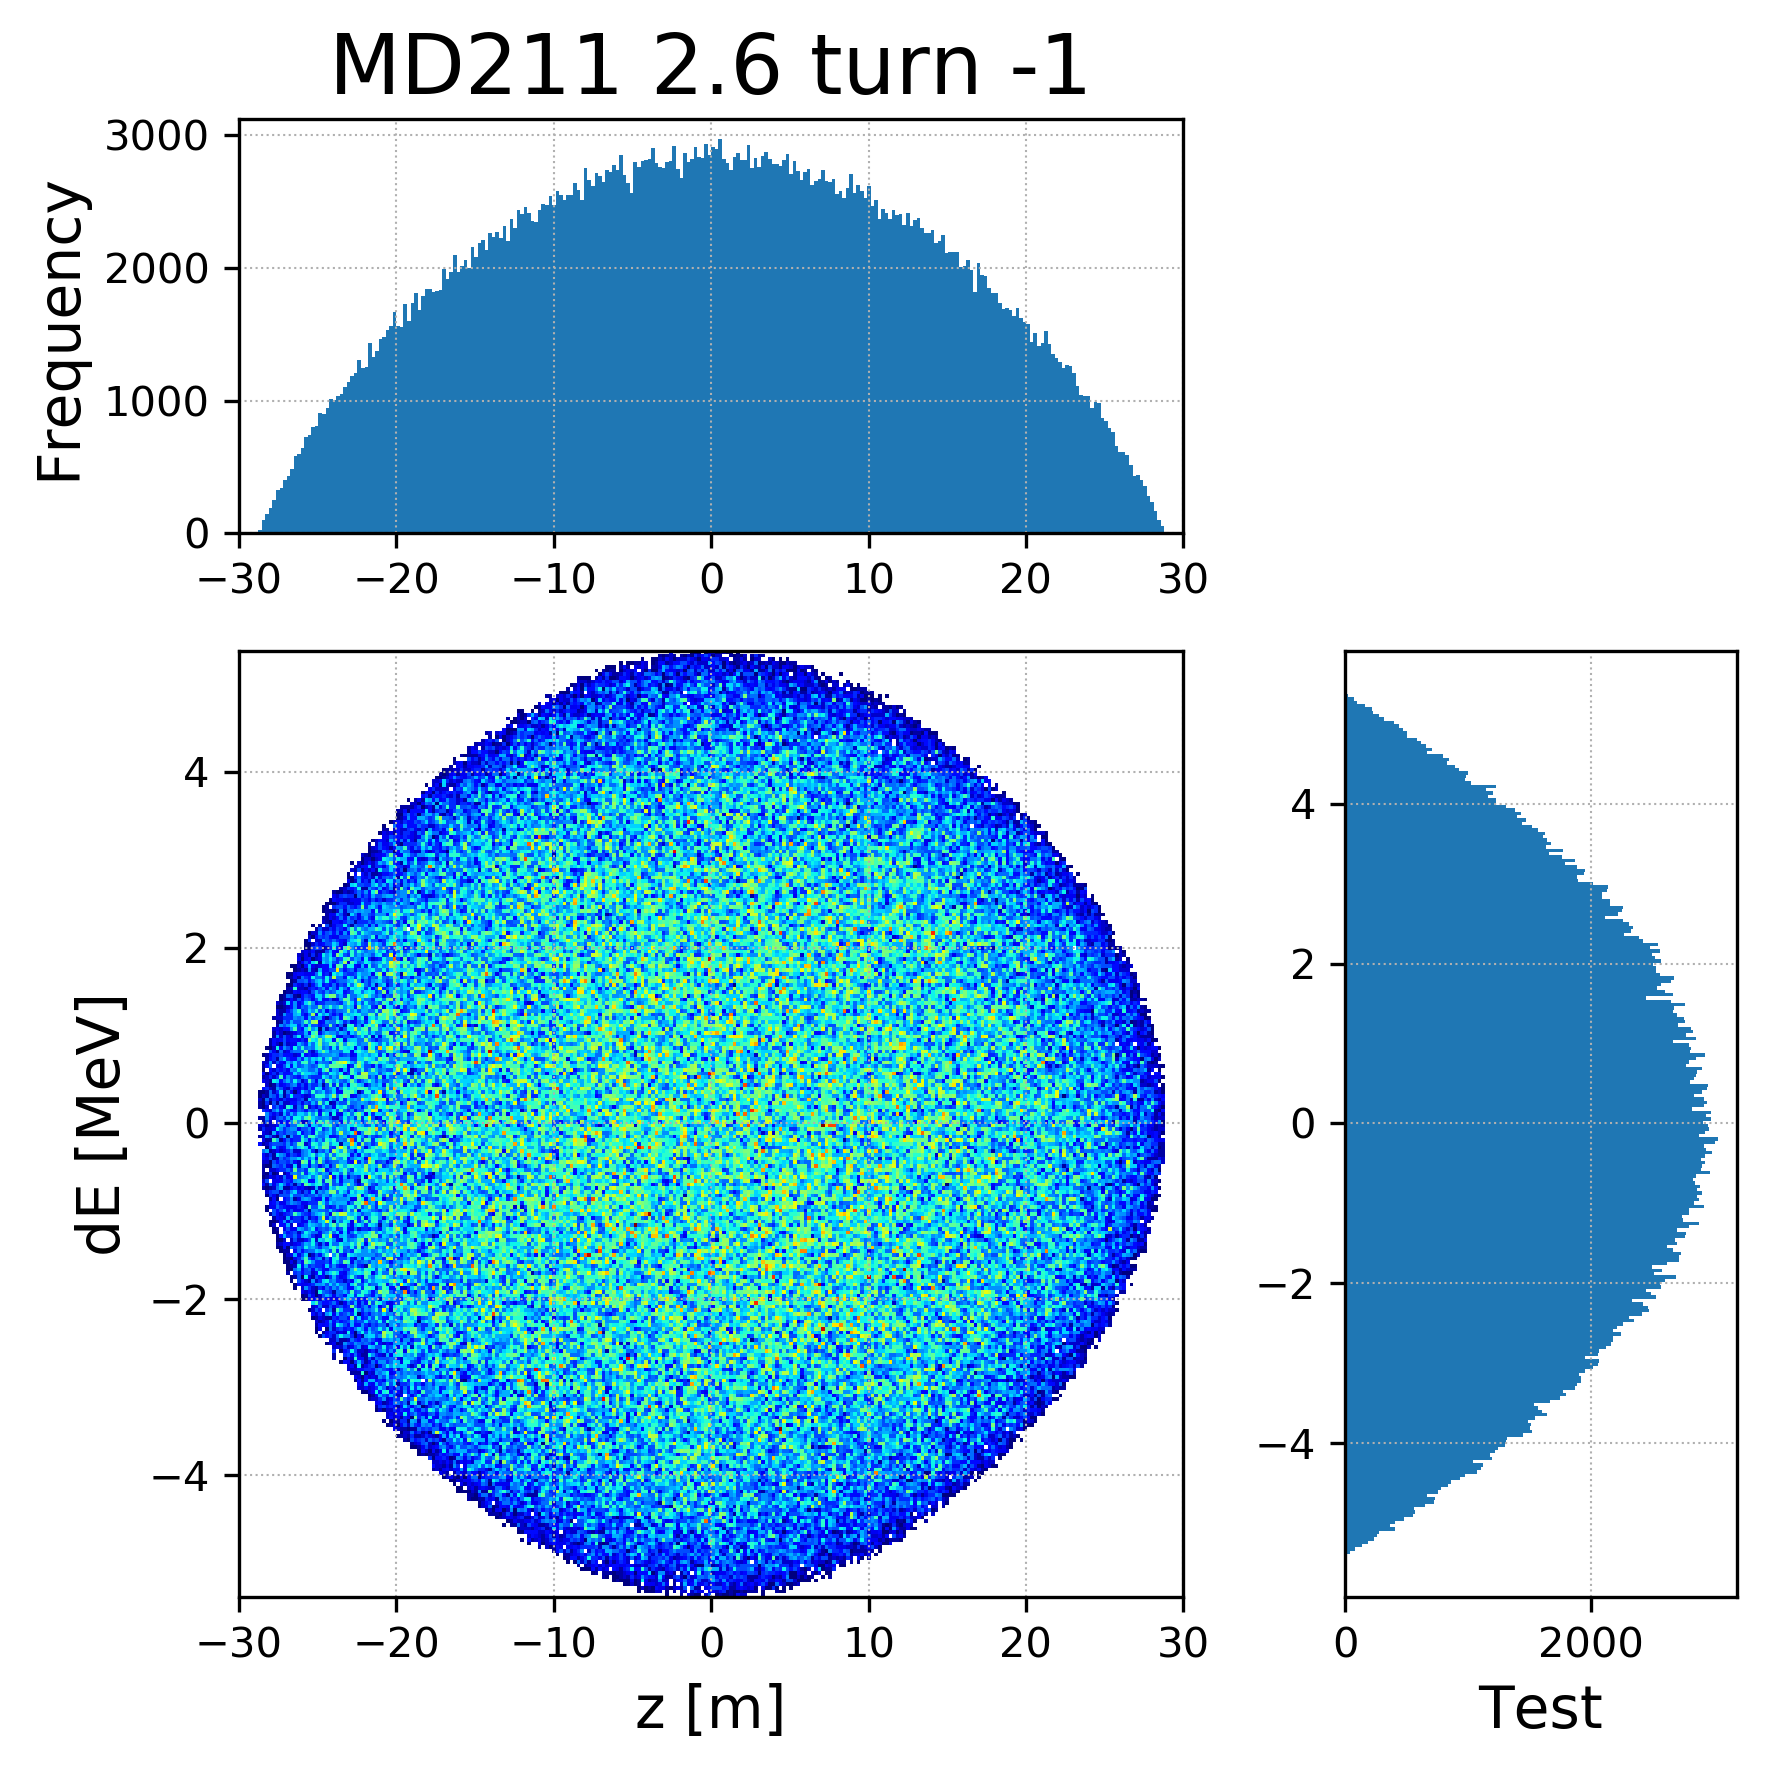

In [15]:
bin_size = 256
turn = -1
zdE_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['z'][0][0][0])
    dE = np.array(dd1[key]['particles']['dE'][0][0][0])*1E3
    t = z_to_time(z)*1E9
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('z [m]')
    plt.ylabel('dE [MeV]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_z_dE_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

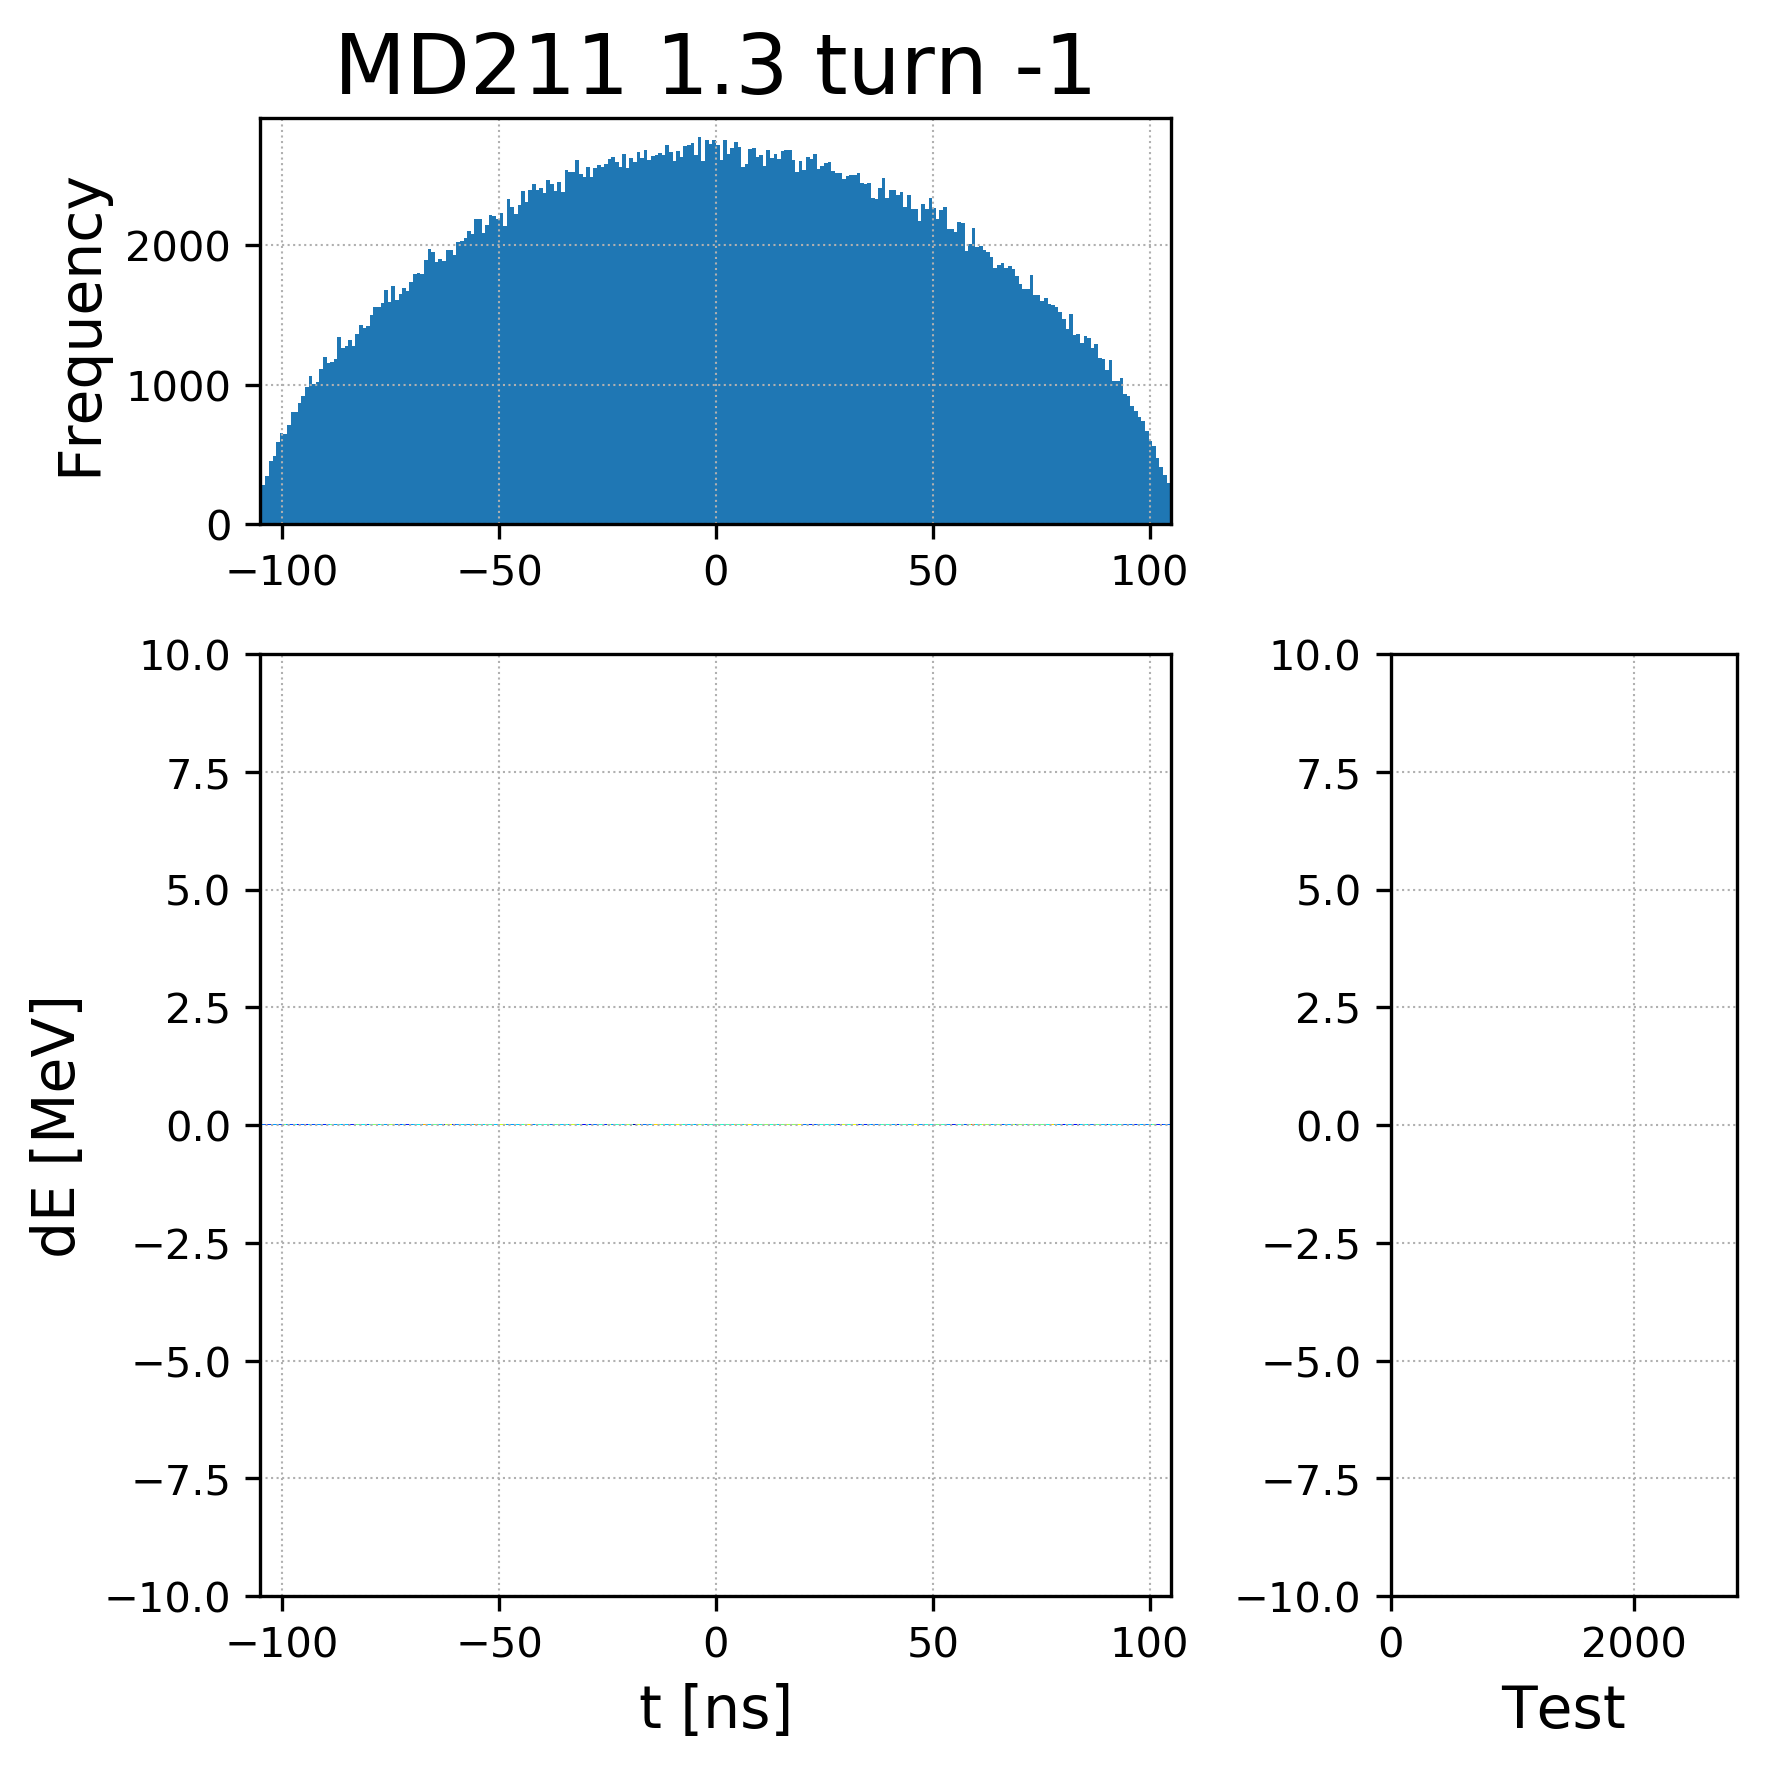

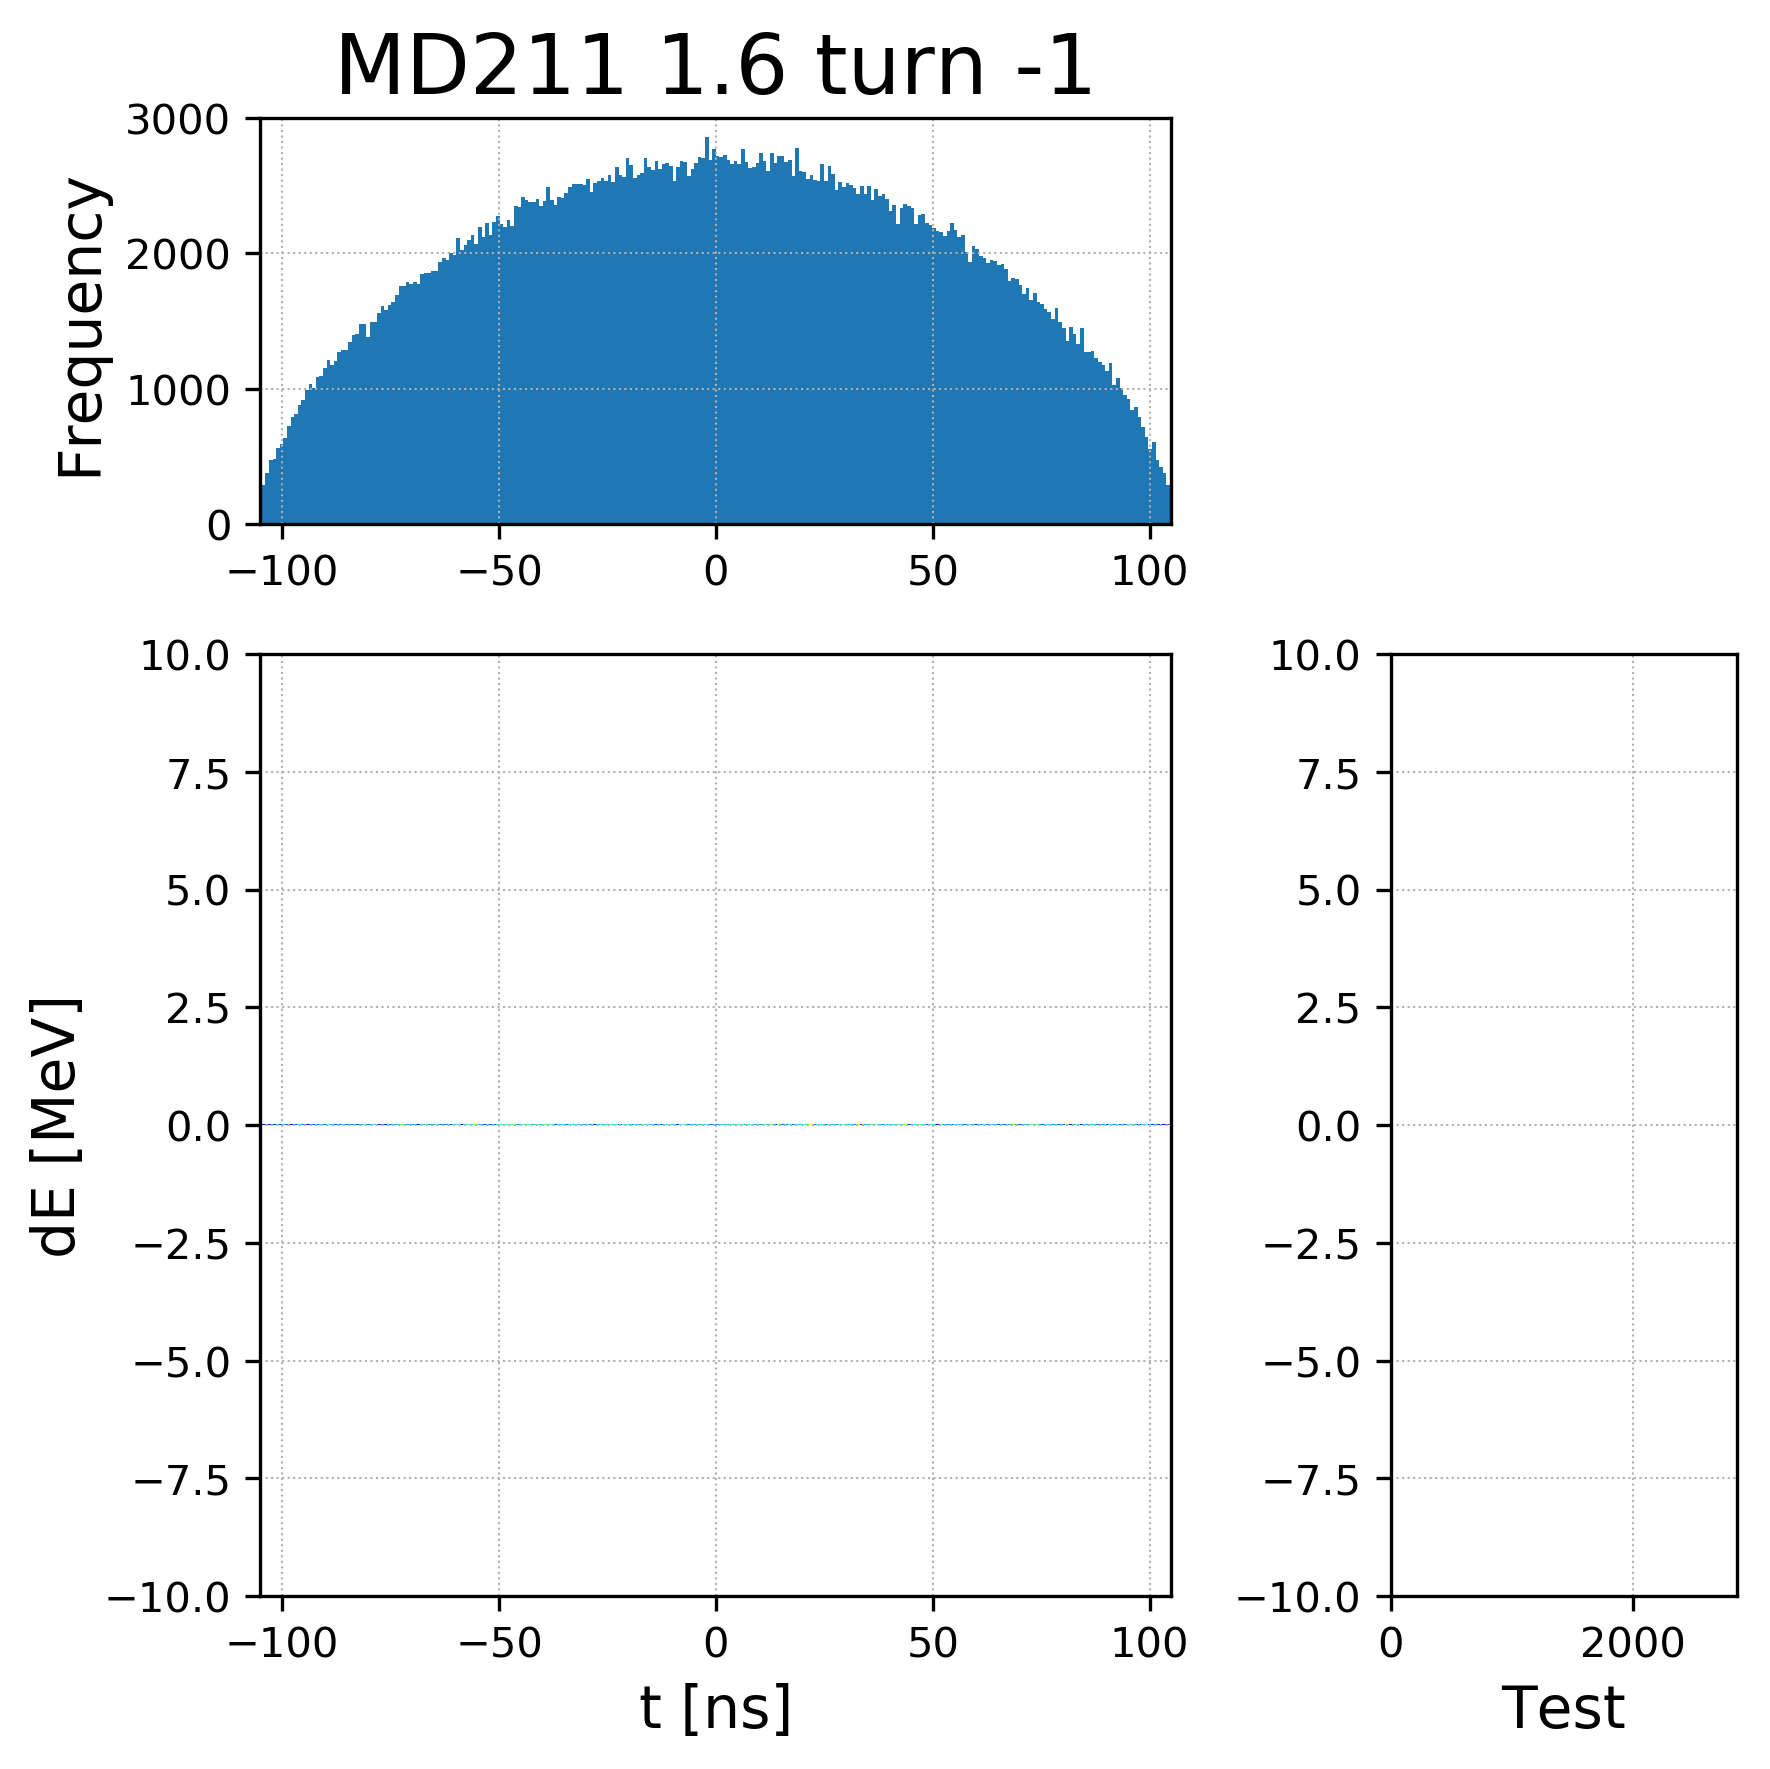

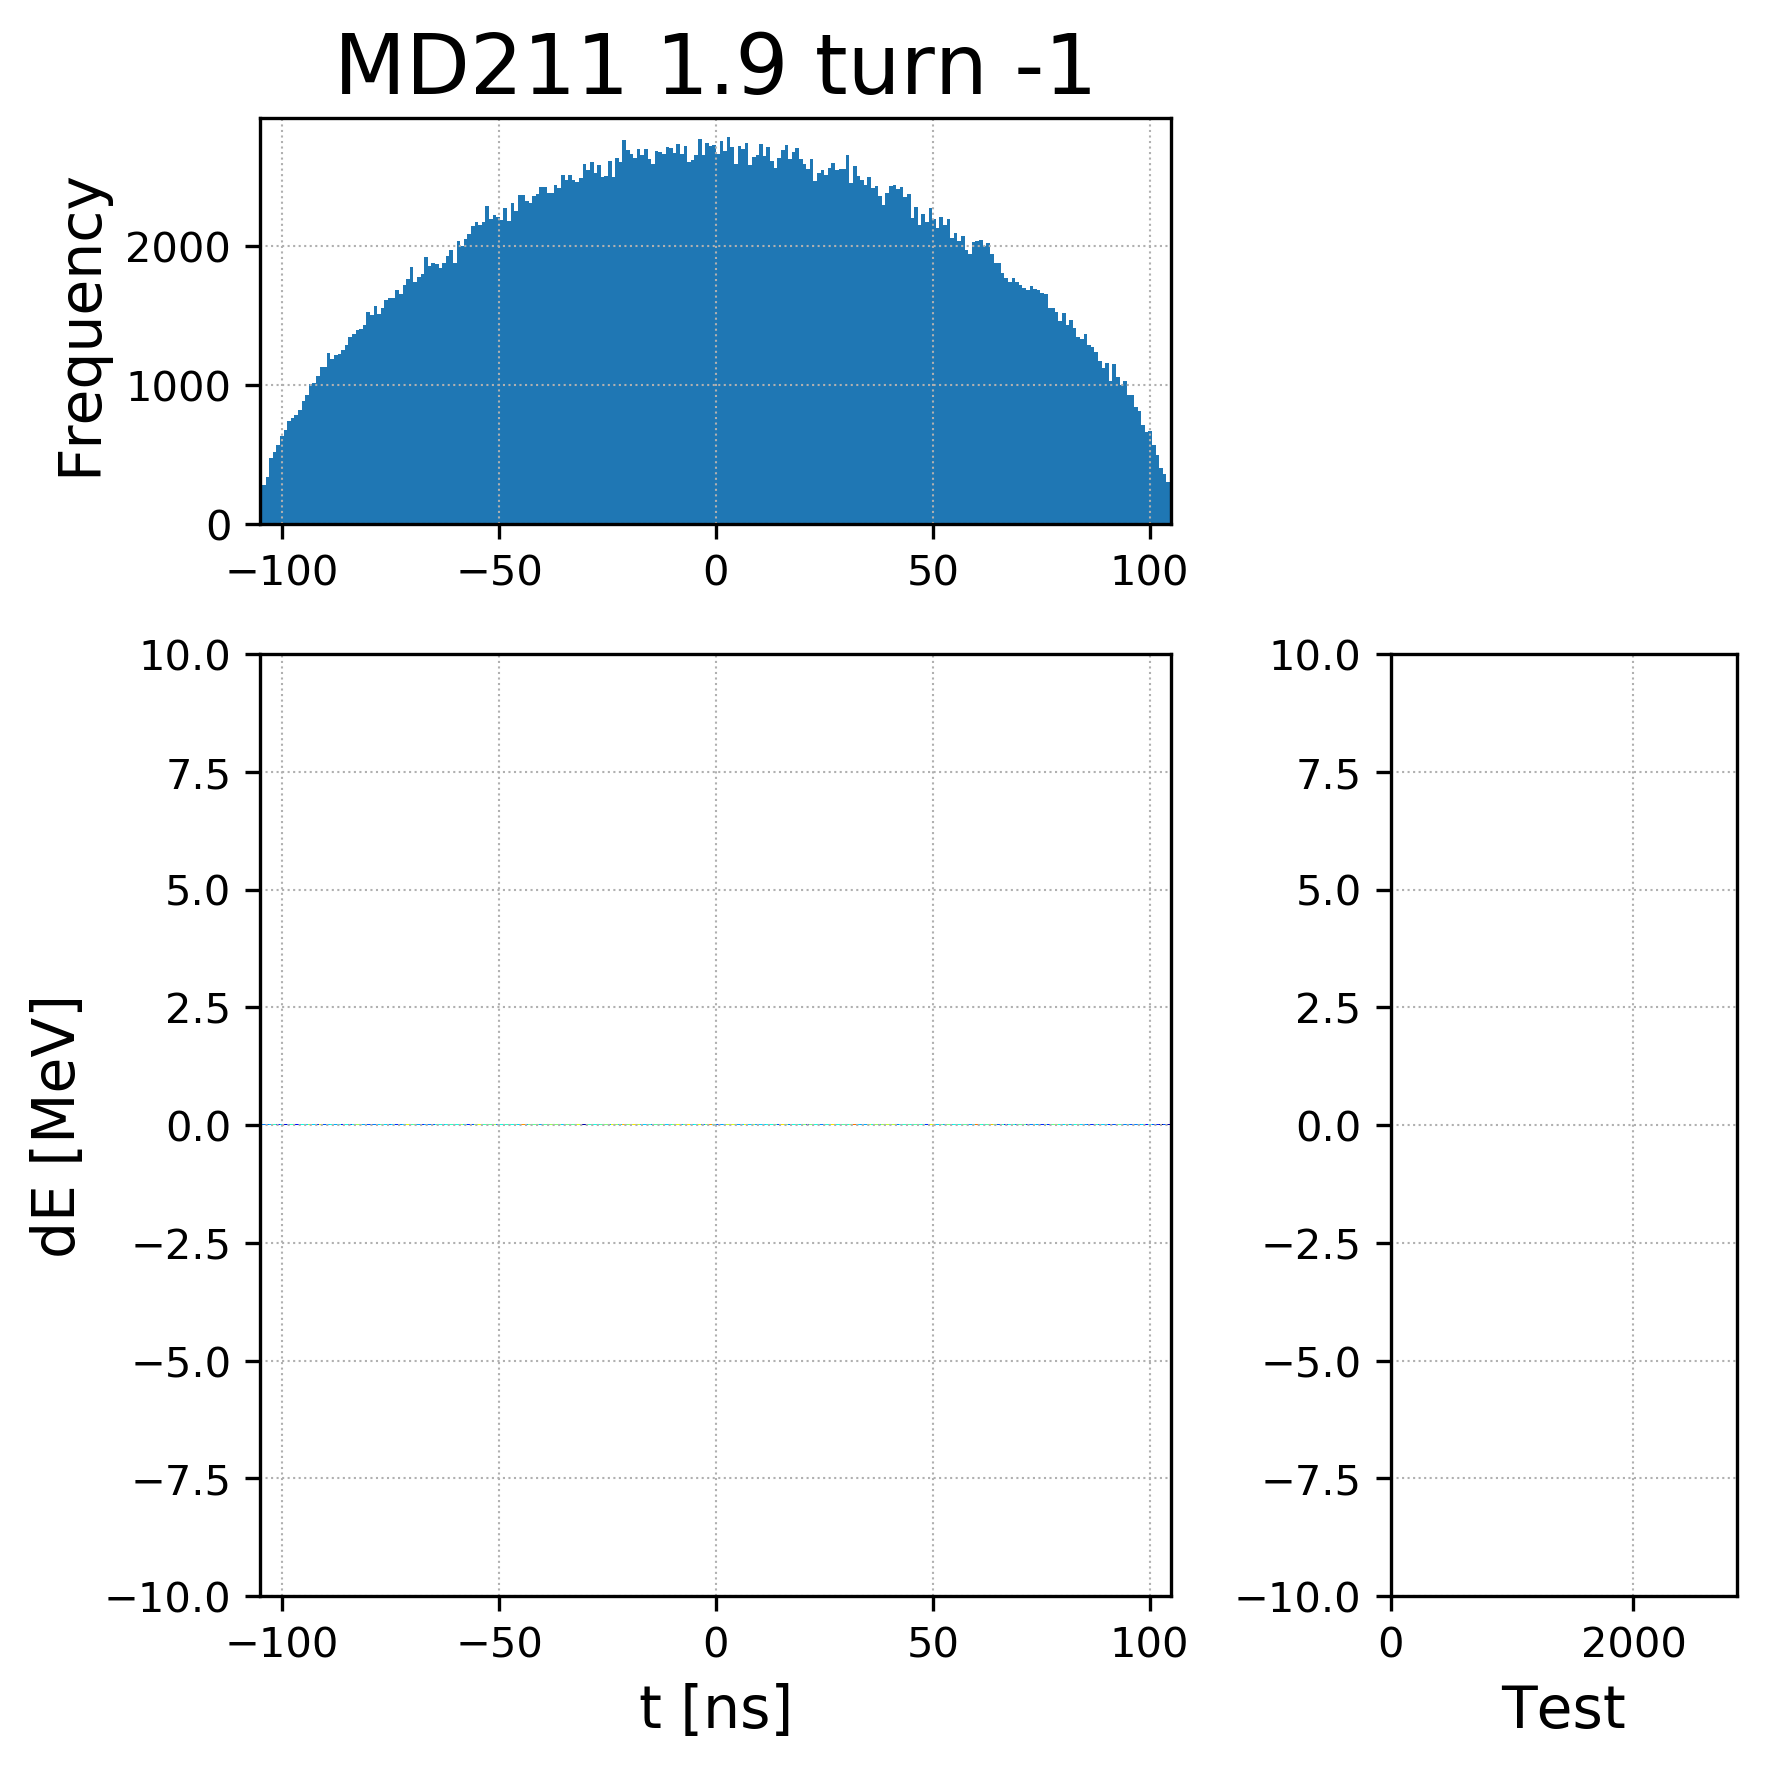

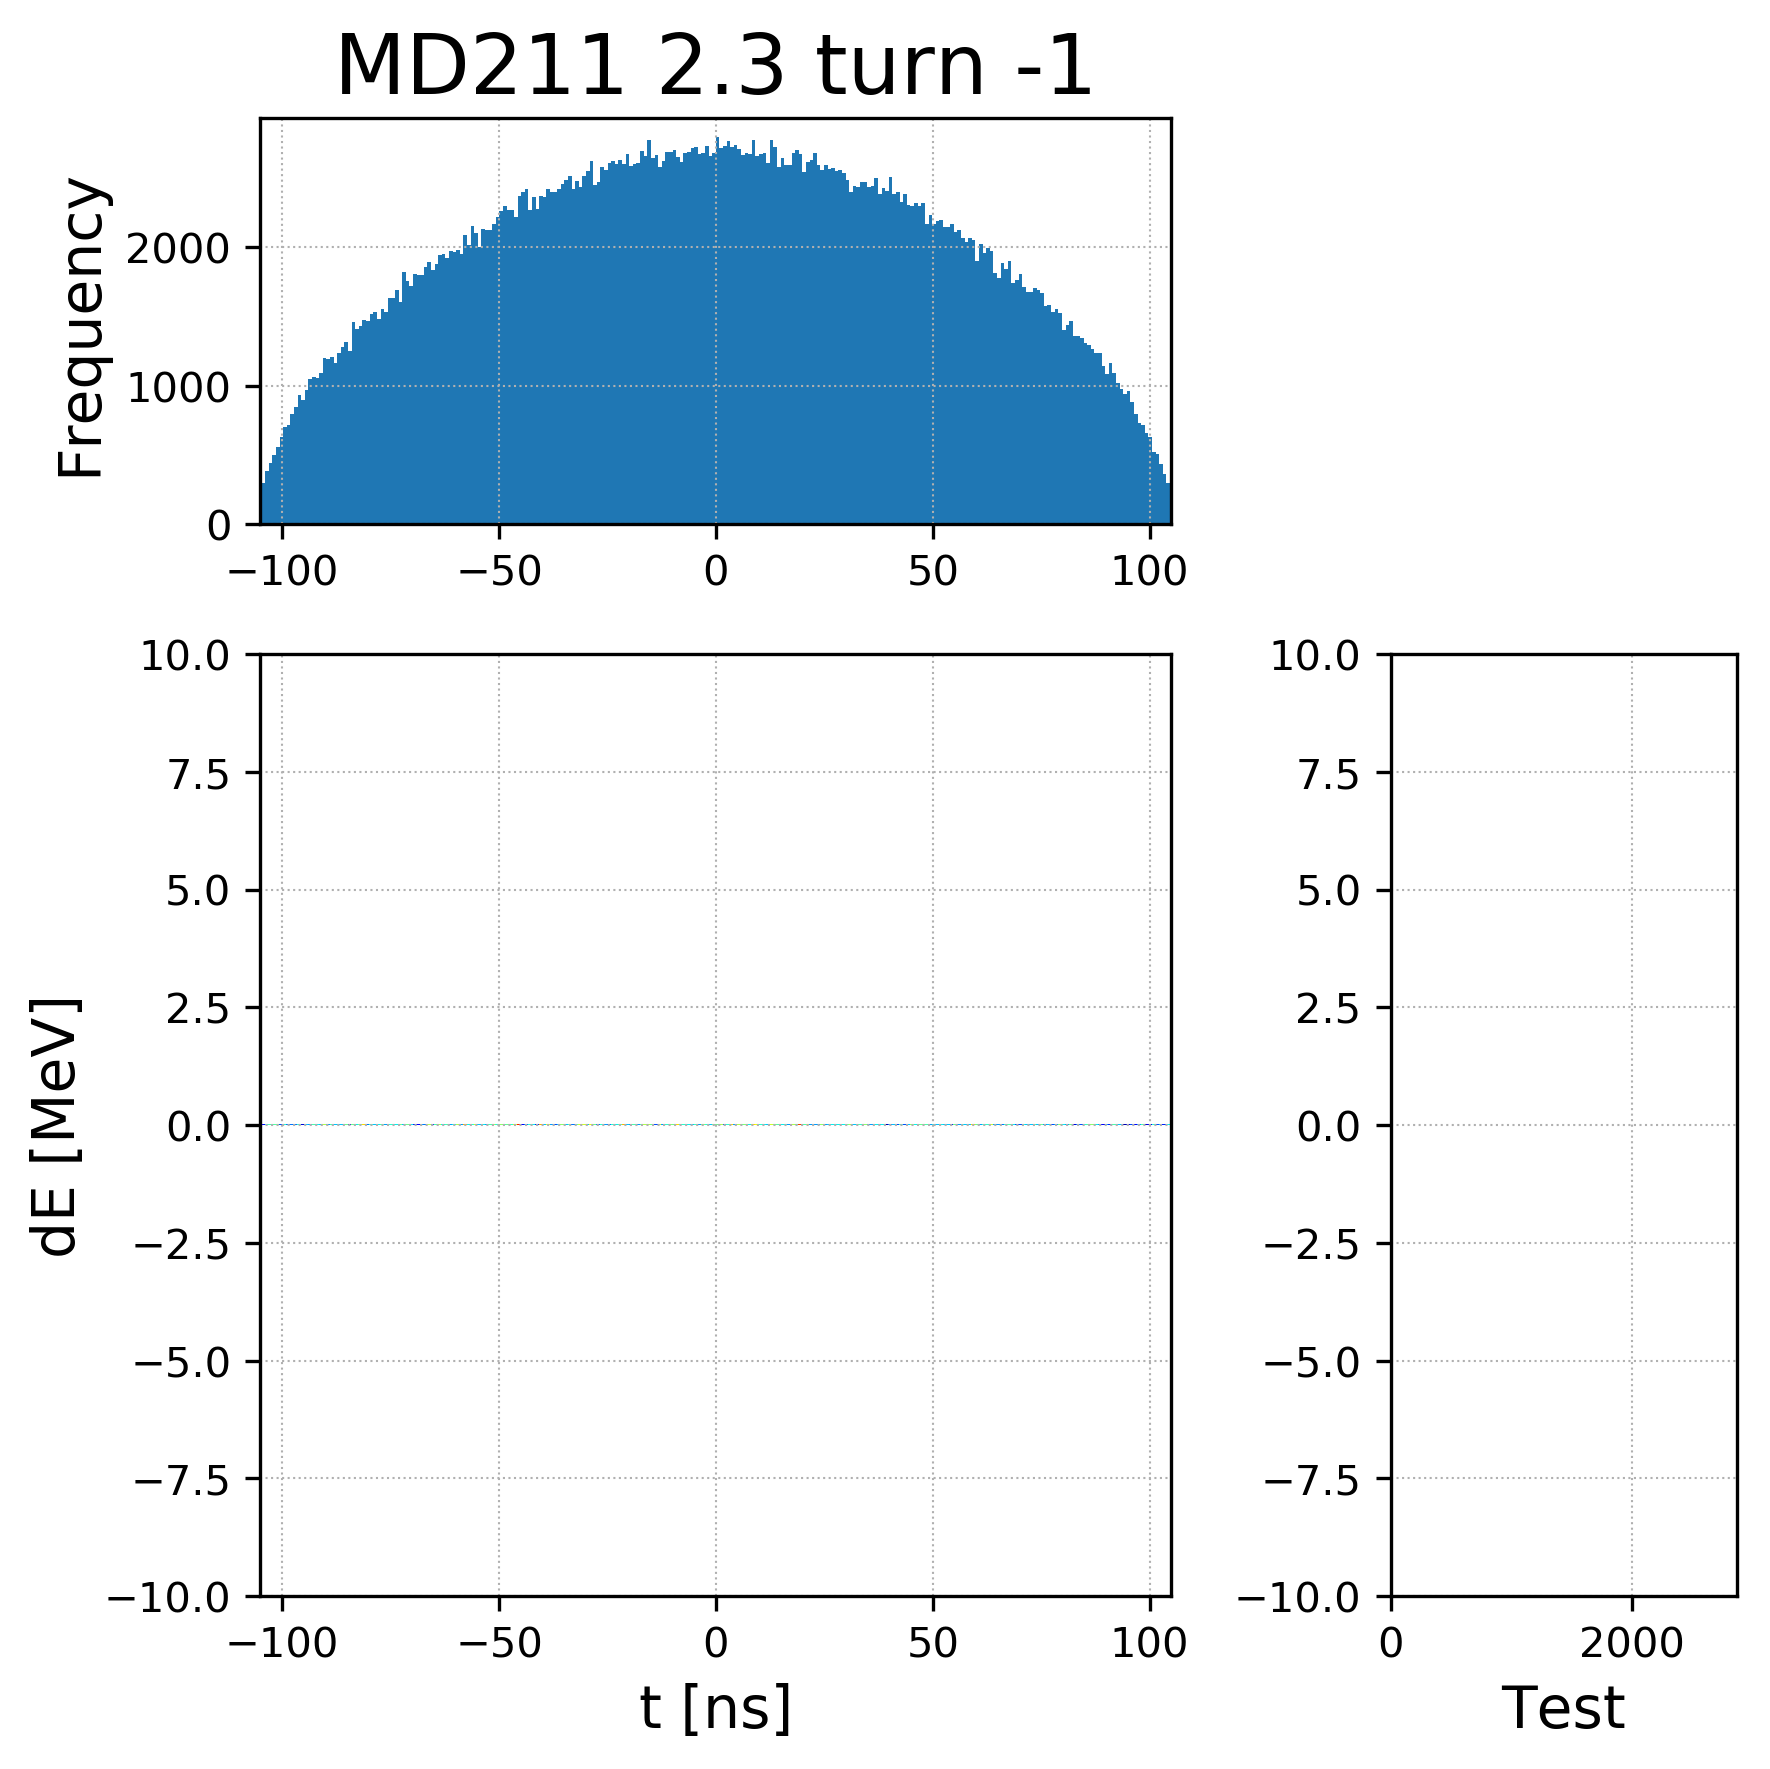

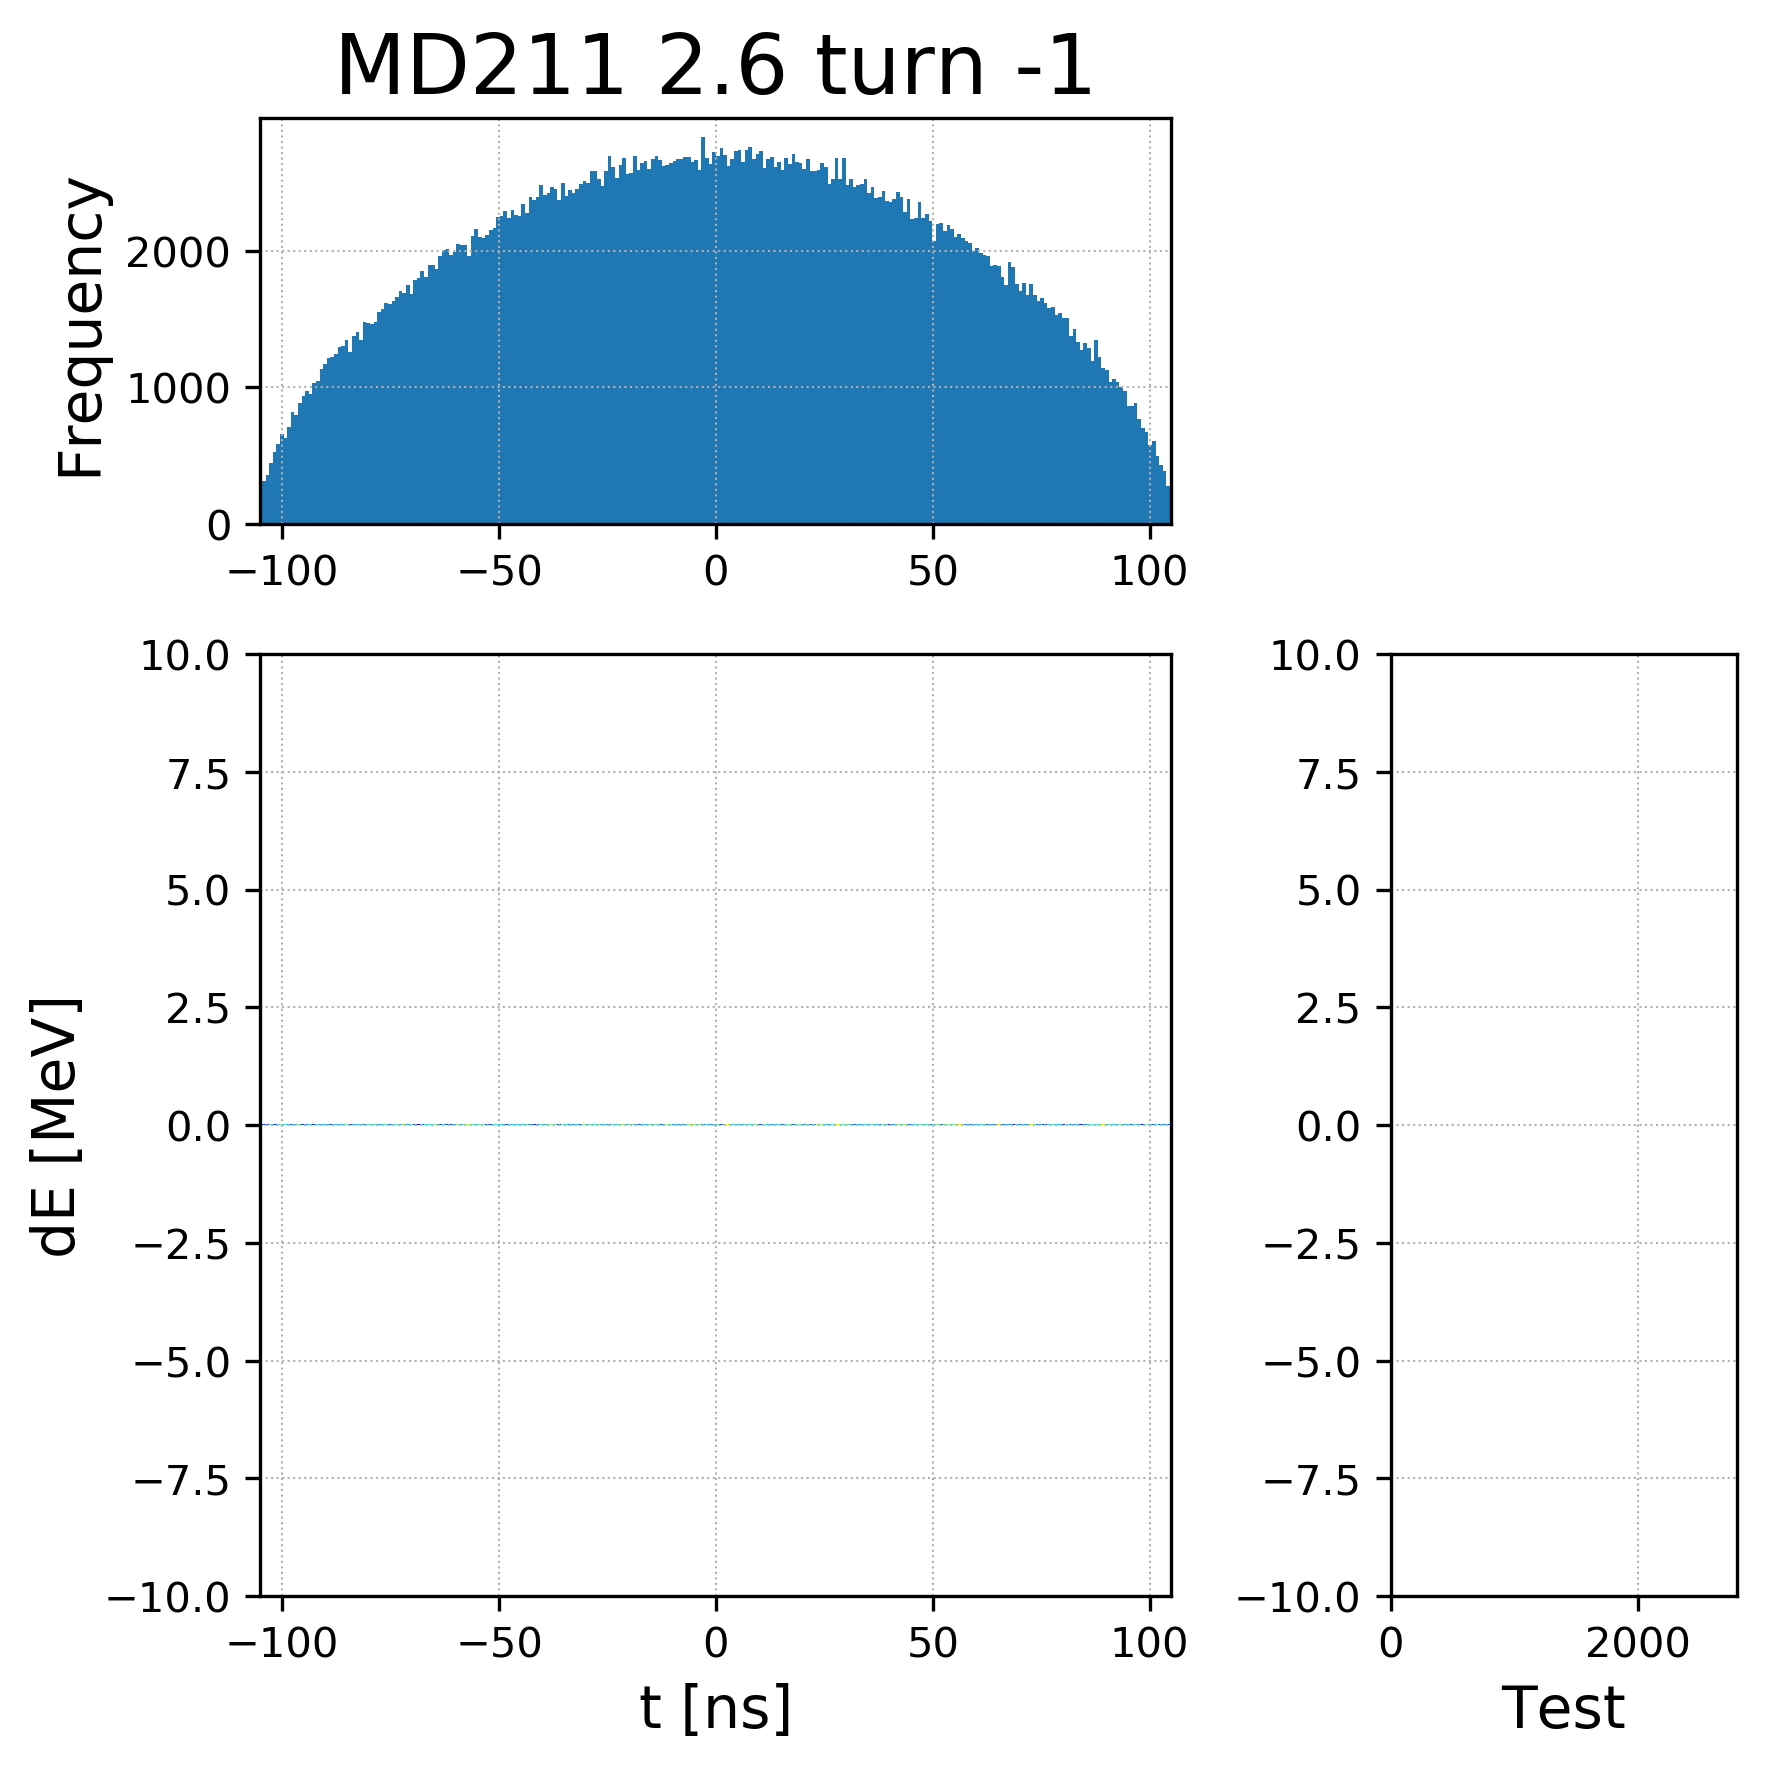

In [16]:
bin_size = 256
turn = -1
zdE_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['z'][0][0][0])
    dE = np.array(dd1[key]['particles']['dE'][0][0][0])*1E3
    t = z_to_time(z)*1E9
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(t, bins=bin_size, range=(np.min(t), np.max(t))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-105, 105)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(t, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(t), np.max(t)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('t [ns]')
    plt.ylabel('dE [MeV]')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.xlim(-105, 105)
    plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Test')
    plt.grid(which='both', ls=':', lw=0.5)
    plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_t_dE_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)